In [89]:
import pandas as pd
import torch
import matplotlib.pyplot as plt

from constants import ALL_COLS, LABEL

In [126]:
model = torch.nn.Sequential(
    torch.nn.Linear(len(ALL_COLS), 64), 
    torch.nn.ReLU(),
    
    torch.nn.Linear(64, 32),
    torch.nn.ReLU(),
    
    torch.nn.Linear(32, 2)   
)

# Train

In [127]:
opt = torch.optim.Adam(model.parameters(), lr=0.0001)
m = torch.nn.LogSoftmax(dim=1)
nll_loss = torch.nn.NLLLoss()

raw_df = pd.read_csv('data_raw/train.csv')
raw_train = torch.tensor(raw_df[ALL_COLS].values, dtype=torch.float32)
raw_label = torch.tensor(raw_df[LABEL].values, dtype=torch.long)


In [128]:
all_loss = []
for _ in range(500):
    loss = nll_loss(m(model(raw_train)), raw_label)
    all_loss.append(loss.detach().numpy())

    opt.zero_grad()
    loss.backward()
    opt.step()

    if _%50==0:
        print(loss)

tensor(18.1457, grad_fn=<NllLossBackward0>)
tensor(0.8336, grad_fn=<NllLossBackward0>)
tensor(0.6426, grad_fn=<NllLossBackward0>)
tensor(0.6348, grad_fn=<NllLossBackward0>)
tensor(0.6243, grad_fn=<NllLossBackward0>)
tensor(0.6189, grad_fn=<NllLossBackward0>)
tensor(0.6140, grad_fn=<NllLossBackward0>)
tensor(0.6098, grad_fn=<NllLossBackward0>)
tensor(0.6065, grad_fn=<NllLossBackward0>)
tensor(0.6038, grad_fn=<NllLossBackward0>)


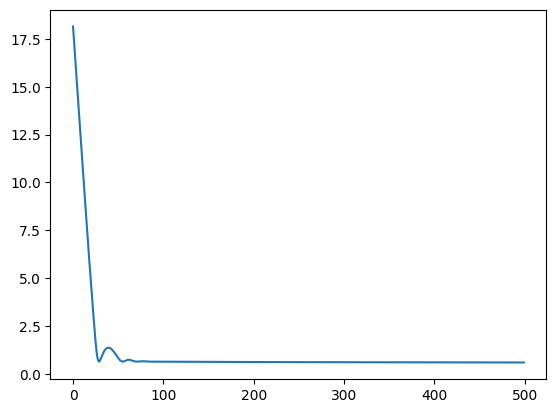

In [129]:
plt.plot(all_loss)

# Test

In [152]:
test_df = pd.read_csv('data_raw/test.csv')
raw_test = torch.tensor(test_df[ALL_COLS].values, dtype=torch.float32)
submit_df = test_df[['Id']].copy()

In [154]:
submit_df.loc[:, 'y'] = model(raw_test).argmax(dim=1).reshape(-1,1).detach().numpy()

In [160]:
submit_df.to_csv('data_submissions/init_submit.csv', index=False)